## DataLoaders requirements:

* Use X and y
* In memory or on disk np.arrays
* Use item tfms and/ or batch tfms
* Show batch (with tfms)
* Good performance
* Slice the dataset 
* Pass batch tfms

### Prepare environment

In [1]:
import sys
import os
ISCOLAB = 'google.colab' in sys.modules
if ISCOLAB:
    if not os.path.isdir('/content/timeseriesAI2'):
        !pip install git+https://github.com/fastai/fastai2 
        !pip install git+https://github.com/fastai/fastcore 
        !pip install pyunpack
        !pip install sktime
        !git clone https://github.com/timeseriesAI/timeseriesAI2.git
        %cd timeseriesAI2
    else: 
        path = !pwd
        if path != ['/content/timeseriesAI2']: 
            %cd timeseriesAI2
        !pwd

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

In [3]:
from fastai2.torch_core import *
from fastai2.data.all import *
from fastai2.learner import *
from fastai2.metrics import *
from fastai2.callback.all import *

In [4]:
from timeseries.imports import *
from timeseries.utils import *
from timeseries.data import *
from timeseries.core import *
from timeseries.models import *

In [5]:
def cycle_dl(dl):
    for x,y in iter(dl): pass

In [6]:
if not os.path.exists('../data'): os.makedirs('../data')
    
X_1000_2_10_in_memory = np.random.rand(1000, 2, 10).astype('float32')
np.save('../data/X_1000_2_10.npy', X_1000_2_10_in_memory)
X_1000_2_10_on_disk = np.load('../data/X_1000_2_10.npy', mmap_mode='r')

X_1000_20_100_in_memory = np.random.rand(1000, 20, 100).astype('float32')
np.save('../data/X_1000_20_100.npy', X_1000_20_100_in_memory)
X_1000_20_100_on_disk = np.load('../data/X_1000_20_100.npy', mmap_mode='r')

X_1000_200_10_in_memory = np.random.rand(1000, 200, 10).astype('float32')
np.save('../data/X_1000_200_10.npy', X_1000_200_10_in_memory)
X_1000_200_10_on_disk = np.load('../data/X_1000_200_10.npy', mmap_mode='r')

X_1000_2_1000_in_memory = np.random.rand(1000, 2, 1000).astype('float32')
np.save('../data/X_1000_2_1000.npy', X_1000_2_1000_in_memory)
X_1000_2_1000_on_disk = np.load('../data/X_1000_2_1000.npy', mmap_mode='r')

X_100_20_1000_in_memory = np.random.rand(100, 20, 1000).astype('float32')
np.save('../data/X_100_20_1000.npy', X_100_20_1000_in_memory)
X_100_20_1000_on_disk = np.load('../data/X_100_20_1000.npy', mmap_mode='r')

X_1000_20_1000_in_memory = np.random.rand(1000, 20, 1000).astype('float32')
np.save('../data/X_1000_20_1000.npy', X_1000_2_1000_in_memory)
X_1000_20_1000_on_disk = np.load('../data/X_1000_20_1000.npy', mmap_mode='r')

X_10000_2_10_in_memory = np.random.rand(10000, 2, 10).astype('float32')
np.save('../data/X_10000_2_10.npy', X_10000_2_10_in_memory)
X_10000_2_10_on_disk = np.load('../data/X_10000_2_10.npy', mmap_mode='r')

# StarLight valid like
X_1000_1_1024_in_memory = np.random.rand(1000, 1, 1024).astype('float32')
np.save('../data/X_1000_1_1024.npy', X_1000_1_1024_in_memory)
X_1000_1_1024_on_disk = np.load('../data/X_1000_1_1024.npy', mmap_mode='r')

X_8236_1_1024_in_memory = np.random.rand(8236, 1, 1024).astype('float32')
np.save('../data/X_8236_1_1024.npy', X_8236_1_1024_in_memory)
X_8236_1_1024_on_disk = np.load('../data/X_8236_1_1024.npy', mmap_mode='r')

X_starlight_in_memory = concat(X_1000_1_1024_in_memory, X_8236_1_1024_in_memory)
np.save('../data/X_starlight.npy', X_starlight_in_memory)
X_starlight_on_disk = np.load('../data/X_starlight.npy', mmap_mode='r')
splits = (L(list(np.arange(len(X_1000_1_1024_in_memory)))), 
          L(list(np.arange(len(X_1000_1_1024_in_memory), len(X_starlight_in_memory)))))

y_100 = np.random.randint(0, 10, 100)
y_1000 = np.random.randint(0, 10, 1000)
y_10000 = np.random.randint(0, 10, 10000)
y_8236 = np.random.randint(0, 10, 8236)
y_starlight = concat(y_1000, y_8236)

Xs_in_memory = [X_1000_20_100_in_memory, X_1000_200_10_in_memory, X_1000_2_1000_in_memory, 
               X_100_20_1000_in_memory, X_1000_20_1000_in_memory, X_10000_2_10_in_memory, X_8236_1_1024_in_memory]
Xs_on_disk = [X_1000_20_100_on_disk, X_1000_200_10_on_disk, X_1000_2_1000_on_disk, 
               X_100_20_1000_on_disk, X_1000_20_1000_on_disk, X_10000_2_10_on_disk, X_8236_1_1024_on_disk]
ys = [y_1000, y_1000, y_1000, y_100, y_1000, y_10000, y_8236]

### Native Pytorch dataloader

In [7]:
# Native Pytorch
class NumpyDataset(torch.utils.data.Dataset):
    def __init__(self, X, y=None, sel_vars=None, sel_steps=None):
        self.X, self.y = X, y
        self.sel_vars =  slice(None) if sel_vars is None else sel_vars
        self.sel_steps =  slice(None) if sel_steps is None else sel_steps

    def __getitem__(self, idx):
        return (self.X[idx, self.sel_vars, self.sel_steps], ) if self.y is None \
        else (self.X[idx, self.sel_vars, self.sel_steps], self.y[idx])

    def __len__(self):
        return len(self.X)

In [8]:
for x_, y_ in zip(Xs_in_memory, ys):
    ds    = NumpyDataset(x_, y_)
    dl    = torch.utils.data.DataLoader(dataset=ds, batch_size=128)
    print(f'shape: {str(x_.shape):20}   numel: {len(x_.ravel()):12,}')
    %timeit cycle_dl(dl)
    print()

shape: (1000, 20, 100)        numel:    2,000,000
31.7 ms ± 1.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

shape: (1000, 200, 10)        numel:    2,000,000
35.9 ms ± 2.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

shape: (1000, 2, 1000)        numel:    2,000,000
35.6 ms ± 3.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

shape: (100, 20, 1000)        numel:    2,000,000
9.37 ms ± 270 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

shape: (1000, 20, 1000)       numel:   20,000,000
85.1 ms ± 4.65 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

shape: (10000, 2, 10)         numel:      200,000
312 ms ± 22.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

shape: (8236, 1, 1024)        numel:    8,433,664
251 ms ± 9.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



In [9]:
# test larger batch size
x_ = X_8236_1_1024_in_memory
y_ = y_8236
ds    = NumpyDataset(x_, y_)
dl    = torch.utils.data.DataLoader(dataset=ds, batch_size=128)
xb,yb = next(iter(dl))
print(f'shape: {str(x_.shape):20}   numel: {len(x_.ravel()):12,}   bs: {len(xb)}')
%timeit cycle_dl(dl)
print()

ds    = NumpyDataset(x_, y_)
dl    = torch.utils.data.DataLoader(dataset=ds, batch_size=1280)
xb,yb = next(iter(dl))
print(f'shape: {str(x_.shape):20}   numel: {len(x_.ravel()):12,}   bs: {len(xb)}')
%timeit cycle_dl(dl)
print()

shape: (8236, 1, 1024)        numel:    8,433,664   bs: 128
274 ms ± 36.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

shape: (8236, 1, 1024)        numel:    8,433,664   bs: 1280
250 ms ± 9.22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



**Key learning:** 

The number of dimensions or length of the time series doesn't have a significant impact on dataloader's performance. 

Performance is mostly determined by the number of samples, not the number of batches.

Pytorch native dataloader is pretty fast, although it misses these 3 requirements: 

* In memory or on disk np.arrays
* Use item tfms and/ or batch tfms
* Show batch (with tfms)

I'll modify the default_collate to allow np.memmap as well. This shouldn't have any impact on performance.

In [10]:
def dataloader(dataset,
               batch_size=1,
               shuffle=False,
               sampler=None,
               batch_sampler=None,
               num_workers=0,
               collate_fn=np_collate,
               pin_memory=False,
               drop_last=False,
               timeout=0,
               worker_init_fn=None,
               multiprocessing_context=None):

    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn,
        multiprocessing_context=multiprocessing_context)


NumpyDataset.dataloader = dataloader

In [11]:
# test in memory vs on disk arrays
x_ = X_8236_1_1024_in_memory
y_ = y_8236
ds    = NumpyDataset(x_, y_)
dl    = torch.utils.data.DataLoader(dataset=ds, batch_size=128)
xb,yb = next(iter(dl))
print(f'shape: {str(x_.shape):20}   numel: {len(x_.ravel()):12,}   bs: {len(xb)}')
%timeit cycle_dl(dl)
print()

x_ = X_8236_1_1024_in_memory
y_ = y_8236
ds    = NumpyDataset(x_, y_)
dl    = ds.dataloader(batch_size=128)
xb,yb = next(iter(dl))
print(f'shape: {str(x_.shape):20}   numel: {len(x_.ravel()):12,}   bs: {len(xb)}')
%timeit cycle_dl(dl)
print()

x_ = X_8236_1_1024_on_disk
y_ = y_8236
ds    = NumpyDataset(x_, y_)
dl    = ds.dataloader(batch_size=128)
xb,yb = next(iter(dl))
print(f'shape: {str(x_.shape):20}   numel: {len(x_.ravel()):12,}   bs: {len(xb)}')
%timeit cycle_dl(dl)
print()

shape: (8236, 1, 1024)        numel:    8,433,664   bs: 128
278 ms ± 15.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

shape: (8236, 1, 1024)        numel:    8,433,664   bs: 128
240 ms ± 1.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

shape: (8236, 1, 1024)        numel:    8,433,664   bs: 128
354 ms ± 14.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



**Key learnings:**

- The updated collate function (that allows memmap conversion into a tensor) doesn't negetively impact performance when used with np.ndarrays

- data is on disk is 40% slower than in memory, so it's better to pass data in memory if possible. However, performance is still good with data on disk.


So we can now meet 3 of the requirements, but cannot still use tfms or show_batch.

In [12]:
#conversion to TS tensor
class TSDataset(torch.utils.data.Dataset):
    def __init__(self, X, y=None):
        self.X, self.y = X, y
        
    def __getitem__(self, idx):
        if self.y is None: return (self.X[idx], )
        else: return (TSTensor(self.X[idx]), self.y[idx])

    def __len__(self):
        return len(self.X)
    
TSDataset.dataloader = dataloader

In [13]:
# Prior conversion to TSTensor
x_ = X_8236_1_1024_on_disk
y_ = y_8236

ds    = NumpyDataset(x_, y_)
dl    = ds.dataloader(batch_size=128)
xb,yb = next(iter(dl))
print(f'shape: {str(x_.shape):20}   numel: {len(x_.ravel()):12,}   bs: {len(xb)}')
%timeit cycle_dl(dl)
print()

ds    = TSDataset(x_, y_)
dl    = ds.dataloader(batch_size=128)
xb,yb = next(iter(dl))
print(f'shape: {str(x_.shape):20}   numel: {len(x_.ravel()):12,}   bs: {len(xb)}')
%timeit cycle_dl(dl)
print()

shape: (8236, 1, 1024)        numel:    8,433,664   bs: 128
368 ms ± 28 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

shape: (8236, 1, 1024)        numel:    8,433,664   bs: 128
470 ms ± 24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



Conversion to TSTensor makes it is 30-40% slower, so it doesn't seem useful.

### Factory method

In [14]:
x_ = X_starlight_in_memory
y_ = y_starlight
dls = TSDataLoaders.from_numpy(x_, y_, splitter=IndexSplitter(splits[1]), bs=64, val_bs=128)
xb,yb = next(iter(dls.valid))
print(f'shape: {str(x_.shape):20}   numel: {len(x_.ravel()):12,}   bs: {len(xb)}')
%timeit cycle_dl(dls.valid)

shape: (9236, 1, 1024)        numel:    9,457,664   bs: 128
3.55 s ± 217 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Datablock

In [15]:
x_ = X_starlight_in_memory
y_ = y_starlight
getters = [ItemGetter(0), ItemGetter(1)]
dblock = DataBlock(blocks=(TSTensorBlock, CategoryBlock),
                   getters=getters,
                   splitter=IndexSplitter(splits[1]),
                   item_tfms=None,
                   batch_tfms=None)
source = itemify(x_, y_)
dls = dblock.dataloaders(source, bs=64, val_bs=128)
xb,yb = next(iter(dls.valid))
print(f'shape: {str(x_.shape):20}   numel: {len(x_.ravel()):12,}   bs: {len(xb)}')
%timeit cycle_dl(dls.valid)

shape: (9236, 1, 1024)        numel:    9,457,664   bs: 128
3.16 s ± 145 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Datasets + DataLoaders

In [74]:
class NumpyDatasets(FilteredBase):
    "A dataset that creates a tuple from each `tfms`, passed thru `item_tfms`"
    def __init__(self, X=None, y=None, items=None, tfms=None, tls=None, n_inp=None, dl_type=None, preprocess=False, **kwargs):
        super().__init__(dl_type=dl_type)

        #New 4 lines of code
        if tls is None:
            if items is None: items = itemify(X,) if y is None else itemify(X,y)
            assert (tfms is None or len(items[0]) == len(tfms)), f"n_tfms ({len(tfms)}) doesn't match n_items ({len(items[0])})"
            tfms = None if tfms is None else [[ItemGetter(i)] + L(tfms[i]) for i in range(len(items[0]))]
        
        self.tls = L(tls if tls else [TfmdLists(items, t, **kwargs) for t in L(ifnone(tfms,[None]))])
        self.n_inp = (1 if len(self.tls)==1 else len(self.tls)-1) if n_inp is None else n_inp
        
        if preprocess: self.ptls = itemify([tl[:] for tl in self.tls])
        else: self.ptls = self.tls
        self.preprocess = preprocess

    def __getitem__(self, it):
        if self.preprocess: res = self.ptls[it]
        else: res = tuple([tl[it] for tl in self.tls])
        return res if is_indexer(it) else list(zip(*res))

    def __getattr__(self,k): return gather_attrs(self, k, 'tls')
    def __dir__(self): return super().__dir__() + gather_attr_names(self, 'tls')
    def __len__(self): return len(self.tls[0])
    def __iter__(self): return (self[i] for i in range(len(self)))
    def __repr__(self): return coll_repr(self)
    def decode(self, o, full=True): return tuple(tl.decode(o_, full=full) for o_,tl in zip(o,tuplify(self.tls, match=o)))
    def subset(self, i): return type(self)(tls=L(tl.subset(i) for tl in self.tls), n_inp=self.n_inp, preprocess=self.preprocess)
    def _new(self, *args, X=None, y=None, items=None, **kwargs): return super()._new(X=X, y=y, items=items, tfms=self.tfms, 
                                                                                     do_setup=False, **kwargs)
    def overlapping_splits(self): return self.tls[0].overlapping_splits()
    @property
    def splits(self): return self.tls[0].splits
    @property
    def split_idx(self): return self.tls[0].tfms.split_idx
    @property
    def items(self): return self.tls[0].items
    @items.setter
    def items(self, v):
        for tl in self.tls: tl.items = v

    def show(self, o, ctx=None, **kwargs):
        for o_,tl in zip(o,self.tls): ctx = tl.show(o_, ctx=ctx, **kwargs)
        return ctx

    def new_empty(self):
        tls = [tl._new([], split_idx=tl.split_idx) for tl in self.tls]
        return type(self)(tls=tls, n_inp=self.n_inp)

    @contextmanager
    def set_split_idx(self, i):
        old_split_idx = self.split_idx
        for tl in self.tls: tl.tfms.split_idx = i
        yield self
        for tl in self.tls: tl.tfms.split_idx = old_split_idx

In [17]:
x_ = X_starlight_in_memory
y_ = y_starlight

tfms  = [[ToTSTensor], [Categorize()]]
dsets = NumpyDatasets(x_, y_, tfms=tfms, splits=splits)
dls   = DataLoaders.from_dsets(dsets.train, dsets.valid, bs=32, val_bs=128)
xb,yb = next(iter(dls.valid))
print(f'shape: {str(x_.shape):20}   numel: {len(x_.ravel()):12,}   bs: {len(xb)}')
%timeit cycle_dl(dls.valid)

shape: (9236, 1, 1024)        numel:    9,457,664   bs: 64
2.7 s ± 50.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Key insights:**

- Both factory method, datablock API and NumpyDatasets + DataLoaders are all very slow compared to native Pytorch.
- Fastai misses these requirements:

    * In memory or on disk np.arrays
    * Good performance

### Hybrid approach

This approach was suggested by Sylvain Gugger [here](https://forums.fast.ai/t/datablock-with-numpy-input/64848/2?u=oguiza):


"You can create a DataLoaders object from regular PyTorch datasets (though all the visualization methods like show_batch and show_results will fail)."

In [18]:
x_ = X_1000_1_1024_in_memory
y_ = y_1000
train_ds = NumpyDataset(x_, y_)

x_ = X_8236_1_1024_in_memory
y_ = y_8236
valid_ds = NumpyDataset(x_, y_)
dls = DataLoaders.from_dsets(train_ds, valid_ds, batch_size=128)
xb,yb = next(iter(dls.valid))
print(f'shape: {str(x_.shape):20}   numel: {len(x_.ravel()):12,}   bs: {len(xb)}')
%timeit cycle_dl(dls.valid)

shape: (8236, 1, 1024)        numel:    8,433,664   bs: 128
1 loop, best of 3: 798 ms per loop


In [0]:
class TSDataset(torch.utils.data.Dataset):
    def __init__(self, X, y=None, sel_vars=None, sel_steps=None):
        self.X, self.y = X, y
        self.sel_vars =  slice(None) if sel_vars is None else sel_vars
        self.sel_steps =  slice(None) if sel_steps is None else sel_steps

    def __getitem__(self, idx):
        return (TSTensor(self.X[idx, self.sel_vars, self.sel_steps], )) if self.y is None \
        else (TSTensor(self.X[idx, self.sel_vars, self.sel_steps]), self.y[idx])

    def __len__(self):
        return len(self.X)

In [20]:
x_ = X_1000_1_1024_on_disk
y_ = y_1000
train_ds = TSDataset(x_, y_)

x_ = X_8236_1_1024_on_disk
y_ = y_8236
valid_ds = TSDataset(x_, y_)
dls = DataLoaders.from_dsets(train_ds, valid_ds, batch_size=128)
xb,yb = next(iter(dls.valid))
print(f'shape: {str(x_.shape):20}   numel: {len(x_.ravel()):12,}   bs: {len(xb)}')
%timeit cycle_dl(dls.valid)

shape: (8236, 1, 1024)        numel:    8,433,664   bs: 128
1 loop, best of 3: 918 ms per loop


This approach is certainly **much faster** than the default fastai v2. 

TSDataset has the additional benefit that allows you to use data on disk.

However, it's still slower than Pytorch dl. I've found a way to speed this up substantially though:

In [21]:
x_ = X_1000_1_1024_in_memory
y_ = y_1000

train_ds = NumpyDataset(x_, y_)
train_dl = DataLoader(train_ds, bs=128, shuffle=True, drop_last=True)

x_ = X_8236_1_1024_in_memory
y_ = y_8236

valid_ds = NumpyDataset(x_, y_)
valid_dl = DataLoader(valid_ds, bs=128)

dls   = DataLoaders(train_dl, valid_dl)
xb,yb = next(iter(dls.valid))
print(f'shape: {str(x_.shape):20}   numel: {len(x_.ravel()):12,}   bs: {len(xb)}')
%timeit cycle_dl(dls.valid)

shape: (8236, 1, 1024)        numel:    8,433,664   bs: 128
10 loops, best of 3: 53.4 ms per loop


This is **very fast** (similar to Pytorch native dataloader), but it has at least a couple problems: 

* it doesn't allow us to use show_batch. 
* it doesn't allow us to pass an array on disk

Let's see how if we can fix that.

In [94]:
class FloatTensor(TensorBase):
    '''Returns a tensor of type float.int32 and class IntTensor'''
    def __new__(cls, o, dtype=torch.float32, **kwargs): 
        res = tensor(o, dtype=dtype)
        res.__class__ = cls
        res._meta = kwargs
        return res
    
    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        return retain_type(res, self)

    def __repr__(self):
        if self.ndim == 0: return str(self.item())
        else: return f'IntTensor(len:{len(self)})'

    def show(self, ax=None, ctx=None, **kwargs):
        ax = ifnone(ax,ctx)
        if ax is None: fig, ax = plt.subplots(**kwargs)
        ax.axis(xmin=0, xmax=self.shape[-1] - 1)
        ax.set_title(self, weight='bold')
        plt.tight_layout()
        return ax

class IntTensor(TensorBase):
    '''Returns a tensor of type torch.int64 and class IntTensor'''
    def __new__(cls, o, dtype=torch.int64, **kwargs): 
        res = tensor(o, dtype=dtype)
        res.__class__ = cls
        res._meta = kwargs
        return res
    
    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        return retain_type(res, self)

    def __repr__(self):
        if self.ndim == 0: return str(self.item())
        else: return f'IntTensor(len:{len(self)})'

    def show(self, ax=None, ctx=None, **kwargs):
        ax = ifnone(ax,ctx)
        if ax is None: fig, ax = plt.subplots(**kwargs)
        ax.axis(xmin=0, xmax=self.shape[-1] - 1)
        ax.set_title(self, weight='bold')
        plt.tight_layout()
        return ax


class TSDataset(torch.utils.data.Dataset):
    def __init__(self, X, y=None, y_class=IntTensor, sel_vars=None, sel_steps=None):
        self.X, self.y = X, y
        self.y_class = y_class
        self.sel_vars =  slice(None) if sel_vars is None else sel_vars
        self.sel_steps =  slice(None) if sel_steps is None else sel_steps
        
    def __getitem__(self, idx):
        if self.y is None:  return (TSTensor(self.X[idx, self.sel_vars, self.sel_steps]), )
        else:  return (TSTensor(self.X[idx, self.sel_vars, self.sel_steps]), self.y_class(self.y[idx]))

    def __len__(self):
        return len(self.X)

    def __len__(self):
        return len(self.X)

    
class TSDataLoaders(DataLoaders):
    @delegates(plt.subplots)
    def show_batch(self, b=None, max_n=9, nrows=3, ncols=3, figsize=(12, 10), **kwargs):
        if b is None: b = self.one_batch()
        db = self.decode_batch(b, max_n=max_n)
        if nrows is None:
            sqrt = math.sqrt(len(db))
            rows = min(math.ceil(sqrt), len(db))
        if ncols is None: ncols = len(db) // rnows
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize,  **kwargs)
        for tup, ax in zip(db[:nrows ** 2], [axs] if nrows == 1 else axs.flatten()):
            show_tuple(tup, ax=ax)
        plt.tight_layout()
        
    @delegates(plt.subplots)
    def show_batch(self, b=None, max_n=9, nrows=3, ncols=3, figsize=(12, 10), **kwargs):
        if b is None: b = self.one_batch()
#         b = self.decode_batch(b, max_n=max_n)
        b = L(zip(*b))
        if nrows is None: 
            sqrt = math.sqrt(len(b))
            rows = min(math.ceil(sqrt), len(b)) 
        if ncols is None: ncols = len(b) // rnows
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize,  **kwargs)
        for tup, ax in zip(b[:nrows ** 2], [axs] if nrows == 1 else axs.flatten()): 
            show_tuple(tup, ax=ax)
        plt.tight_layout()

In [83]:
x_ = X_1000_1_1024_on_disk
y_ = y_1000

train_ds = TSDataset(x_, y_)
train_dl = DataLoader(train_ds, bs=128, shuffle=True, drop_last=True)

x_ = X_8236_1_1024_on_disk
y_ = y_8236

valid_ds = TSDataset(x_, y_)
valid_dl = DataLoader(valid_ds, bs=128)

dls   = TSDataLoaders(train_dl, valid_dl)
xb,yb = next(iter(dls.valid))
print(f'shape: {str(x_.shape):20}   numel: {len(x_.ravel()):12,}   bs: {len(xb)}')
%timeit cycle_dl(dls.valid)

shape: (8236, 1, 1024)        numel:    8,433,664   bs: 128
916 ms ± 3.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


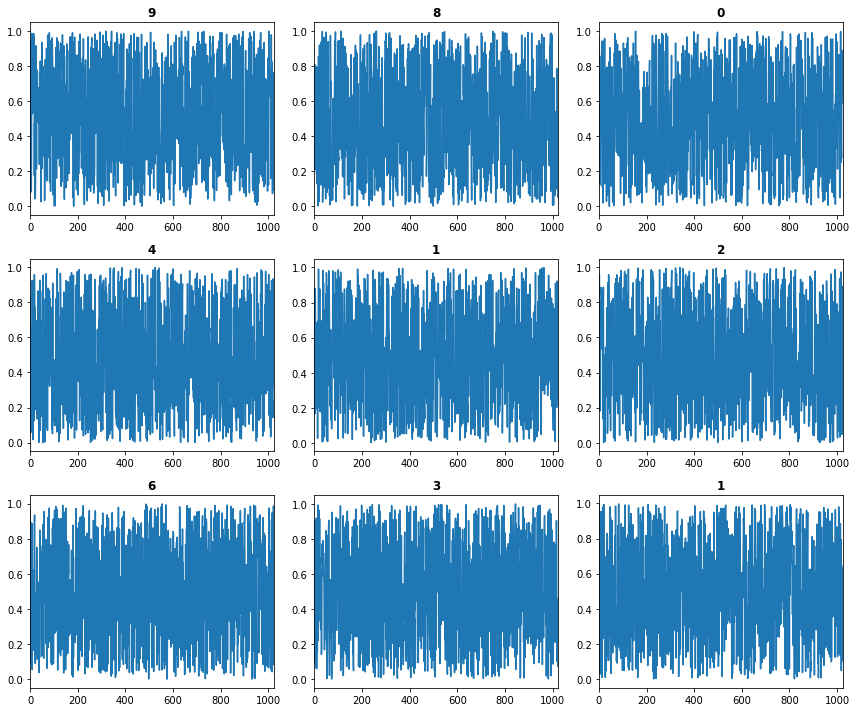

In [36]:
dls.show_batch()

## Sandbox

In [100]:
class TSDataLoader(DataLoaders):
    @delegates(plt.subplots)
    def show_batch(self, b=None, max_n=9, nrows=3, ncols=3, figsize=(12, 10), **kwargs):
        if b is None: b = self.one_batch()
        db = self.decode_batch(b, max_n=max_n)
        if nrows is None:
            sqrt = math.sqrt(len(db))
            rows = min(math.ceil(sqrt), len(db))
        if ncols is None: ncols = len(db) // rnows
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize,  **kwargs)
        for tup, ax in zip(db[:nrows ** 2], [axs] if nrows == 1 else axs.flatten()):
            show_tuple(tup, ax=ax)
        plt.tight_layout()

In [ ]:
x_ = X_starlight_in_memory
y_ = y_starlight

tfms  = [[], [Categorize()]]
dsets = NumpyDatasets(x_, y_, tfms=tfms, splits=splits, preprocess=True)
train_ds = dsets.train
valid_ds = dsets.valid
print(train_ds[0])

In [ ]:
train_dl = TfmdDL(train_ds, bs=128, shuffle=True, drop_last=True)
valid_dl = TfmdDL(valid_ds, bs=128)
dls   = DataLoaders(train_dl, valid_dl)
xb,yb = next(iter(dls.valid))
print(f'shape: {str(x_.shape):20}   numel: {len(x_.ravel()):12,}   batch: {xb.shape}')
%timeit cycle_dl(dls.valid)

In [104]:
train_dl = DataLoader(train_ds, bs=128, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs=128)
dls   = TSDataLoaders(train_dl, valid_dl)
xb,yb = next(iter(dls.valid))
print(f'shape: {str(x_.shape):20}   numel: {len(x_.ravel()):12,}   batch: {xb.shape}')
%timeit cycle_dl(dls.valid)

shape: (9236, 1, 1024)        numel:    9,457,664   batch: torch.Size([128, 1, 1024])


Unhandled exception in thread started by <bound method Thread._bootstrap of <Thread(QueueFeederThread, started daemon 123145585680384)>>


RuntimeError: DataLoader worker (pid 14393) is killed by signal: Unknown signal: 0. 

In [102]:
dls.train.show_batch()

AttributeError: decode_batch

In [77]:
%timeit valid_ds[0]

3.71 µs ± 6.94 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


shape: (9236, 1, 1024)        numel:    9,457,664   bs: 128
331 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [81]:
dls   = DataLoaders.from_dsets(dsets.train, dsets.valid, bs=128)
xb,yb = next(iter(dls.valid))
print(f'shape: {str(x_.shape):20}   numel: {len(x_.ravel()):12,}   bs: {len(xb)}')
%timeit cycle_dl(dls.valid)

shape: (9236, 1, 1024)        numel:    9,457,664   bs: 64
1.02 s ± 6.64 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [57]:
x_ = X_starlight_in_memory
y_ = y_starlight


tfms  = [[ToTSTensor], [Categorize()]]
dsets = NumpyDatasets(x_, y_, tfms=tfms, splits=splits, preprocess=True)
train_ds = itemify([tl[:] for tl in dsets.train.tls])
valid_ds = itemify([tl[:] for tl in dsets.valid.tls])
train_dl = DataLoader(train_ds, bs=128, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs=128)
dls   = DataLoaders(train_dl, valid_dl)
xb,yb = next(iter(dls.valid))
print(f'shape: {str(x_.shape):20}   numel: {len(x_.ravel()):12,}   bs: {len(xb)}')
%timeit cycle_dl(dls.valid)

shape: (9236, 1, 1024)        numel:    9,457,664   bs: 128
171 ms ± 467 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [33]:
%timeit valid_ds[0]

932 µs ± 30.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [56]:
%timeit valid_ds[0]

2.3 µs ± 4.83 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [52]:
ptls = itemify([tl[:] for tl in train_ds.tls])

In [53]:
ptls[0]

(TSTensor(vars:1, len:1024), TensorCategory(1))

In [54]:
%timeit ptls[0]

2.29 µs ± 6.51 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [34]:
x_ = X_1000_1_1024_on_disk
y_ = y_1000

train_ds = TSDataset(x_, y_)
train_dl = DataLoader(train_ds, bs=128, shuffle=True, drop_last=True)

x_ = X_8236_1_1024_on_disk
y_ = y_8236

valid_ds2 = TSDataset(x_, y_)
valid_dl2 = DataLoader(valid_ds2, bs=128)
%timeit valid_ds2[0]

50.4 µs ± 4.85 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
x_ = X_1000_1_1024_on_disk
y_ = y_1000

train_ds = TSDataset(x_, y_)
train_dl = DataLoader(train_ds, bs=128, shuffle=True, drop_last=True)

x_ = X_8236_1_1024_on_disk
y_ = y_8236

valid_ds = TSDataset(x_, y_)
valid_dl = DataLoader(valid_ds, bs=128)

dls   = TSDataLoaders(train_dl, valid_dl)
xb,yb = next(iter(dls.valid))
print(f'shape: {str(x_.shape):20}   numel: {len(x_.ravel()):12,}   bs: {len(xb)}')
%timeit cycle_dl(dls.valid)

In [60]:
tfms  = [[ToTSTensor], [Categorize()]]
dsets = NumpyDatasets(x_, y_, tfms=tfms, splits=splits)
train_ds = dsets.train
valid_ds = dsets.valid